In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Country
;'''

cur.execute(query)

In [3]:
countries_data = cur.fetchall()
countries_df = pd.DataFrame(countries_data)
countries_df.columns = [i[0] for i in cur.description]
countries_df.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [4]:
#Is there a statistical difference in the odds of 
#winning a game when a team is playing in front of their home crowd?

In [5]:
#type of test?
#likelihood of random noise?
#how confident are we?

In [6]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM League
;'''

cur.execute(query)

league_data = cur.fetchall()
league_df = pd.DataFrame(league_data)
league_df.columns = [i[0] for i in cur.description]
league_df.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [7]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]

In [8]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to bsa
dtypes: float64(66), int64(9), object(40)
memory usage: 22.8+ MB


In [9]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Player_Attributes
;'''

cur.execute(query)

player_attrib_data = cur.fetchall()
player_attrib_df = pd.DataFrame(player_attrib_data)
player_attrib_df.columns = [i[0] for i in cur.description]
player_attrib_df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [10]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [11]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team_Attributes
;'''

cur.execute(query)

team_attrib_data = cur.fetchall()
team_attrib_df = pd.DataFrame(team_attrib_data)
team_attrib_df.columns = [i[0] for i in cur.description]
team_attrib_df.head()

,id,team_fifa_api_id,team_api_id,date,buildupplayspeed,buildupplayspeedclass,buildupplaydribbling,buildupplaydribblingclass,buildupplaypassing,buildupplaypassingclass,...,chancecreationshooting,chancecreationshootingclass,chancecreationpositioningclass,defencepressure,defencepressureclass,defenceaggression,defenceaggressionclass,defenceteamwidth,defenceteamwidthclass,defencedefenderlineclass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [12]:
player_df = pd.read_csv('player.csv')
player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


### HYPOTHESIS TEST 1:
##### Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

- H0 (Null Hypothesis): there is no statistical difference in the odds of winning a game when a team is at playing at home
- HA (Alternative Hypothesis): there is a statistical difference in the odds of winning a game when a team is playing at home 

- Alpha = 0.05

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

In [13]:
#create new column home_team_win with binary values - Home team winning = 1, Tie=0.5, Away team winning = 0
match_df['home_team_win'] = np.zeros

match_df['home_team_win'].loc[match_df['home_team_goal'] > match_df['away_team_goal']] = 1
match_df['home_team_win'].loc[match_df['home_team_goal'] < match_df['away_team_goal']] = 0
match_df['home_team_win'].loc[match_df['home_team_goal'] == match_df['away_team_goal']] = 0

In [61]:
match_dff = match_df.dropna()

In [63]:
home_team_win_array = np.array(match_dff['home_team_win'])

sample_means = []
for _ in range(1000):
    sample_mean = np.random.choice(home_team_win_array, size=1000).mean()
    sample_means.append(sample_mean)

In [64]:
np.mean(home_team_win_array)

0.4557321225879682

In [65]:


mu = np.mean(home_team_win_array)
x_bar = np.mean(sample_means)
sigma = np.std(sample_means,ddof=1)
n = len(sample_means)
df = n-1
diff = x_bar - mu

print(mu, x_bar, sigma, n, df, diff)

0.4557321225879682 0.455614 0.015893445366112584 1000 999 -0.00011812258796817243


/Users/krex/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


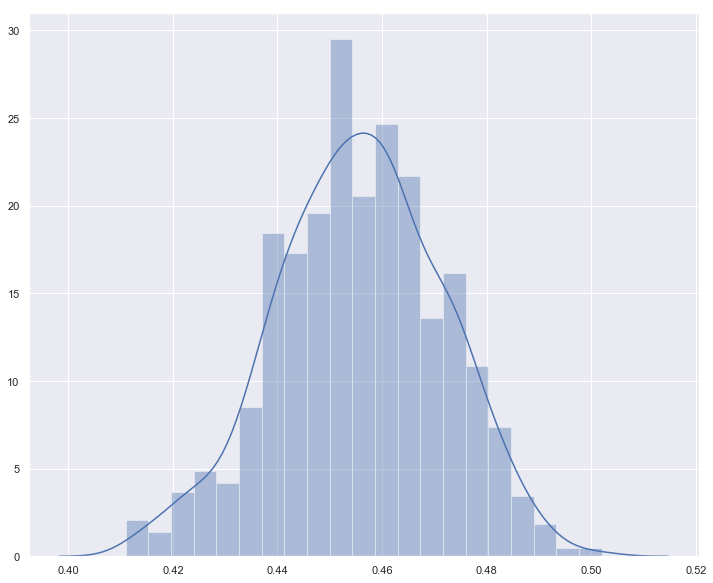

In [66]:
#plot the sample dist
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(sample_means)

In [67]:
t = (x_bar - mu) / (sigma/(np.sqrt(n)))
t

-0.2350254538826845

In [70]:
alpha=0.05

t_crit = scipy.stats.t.ppf(1-alpha, df)
t_crit

1.646380345427535

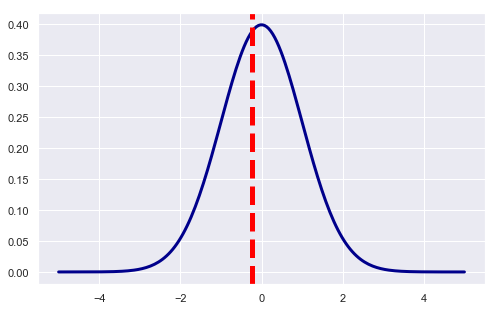

In [71]:
# generate points on the x axis between -5 and 5:
xs = np.linspace(-5, 5, 200)
# use stats.t.pdf to get values on the probability density function for the t-distribution
# the second argument is the degrees of freedom
ys = scipy.stats.t.pdf(xs,df,0,1)
# initialize a matplotlib "figure"
fig = plt.figure(figsize=(8,5))

# get the current "axis" out of the figure
ax = fig.gca()

# plot the lines using matplotlib's plot function:
ax.plot(xs, ys, linewidth=3, color='darkblue')

# plot a vertical line for our measured difference in rates t-statistic
ax.axvline(t, color='red', linestyle='--', lw=5)
plt.show()

## Conclusion:
### We fail to reject the null hypothesis and with 95% confidence state that there is no statistical difference in the odds of winning a game when a team is at playing at home

 ## HYPOTHESIS TEST 2

- NULL: THERE IS NO DIFFERENCE IN WIN RATE BETWEEN 442 and 433
 
- HA: THERE IS A STAT DIFF IN WIN RATE 

In [96]:
from collections import Counter

In [97]:
def OnlyNum(s,oth=''):   
    fomart = '0123456789'   
    for c in s:   
        if (c in fomart) == False:   
             s = s.replace(c,'');   
    return s
#change the format of formation form str, this is for parse formation, only numbers show

In [98]:
home_formation = {}
away_formation = {}
#create two dict to store home team formation and away team formation, key is match_api_id, value is formation like '442'

In [99]:
#lodas of info in the match_df, below is code to grab the columns of interest

match_df_h2 = match_df[['match_api_id','home_team_goal','away_team_goal','home_player_y1','home_player_y2','home_player_y3',
                'home_player_y4','home_player_y5','home_player_y6','home_player_y7','home_player_y8','home_player_y9',
                'home_player_y10','home_player_y11','away_player_y1','away_player_y2','away_player_y3','away_player_y4',
                'away_player_y5','away_player_y6','away_player_y7','away_player_y8','away_player_y9','away_player_y10','away_player_y11','home_team_win']].copy()

In [100]:
match_df_h2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 26 columns):
match_api_id       25979 non-null int64
home_team_goal     25979 non-null int64
away_team_goal     25979 non-null int64
home_player_y1     24158 non-null float64
home_player_y2     24158 non-null float64
home_player_y3     24147 non-null float64
home_player_y4     24147 non-null float64
home_player_y5     24147 non-null float64
home_player_y6     24147 non-null float64
home_player_y7     24147 non-null float64
home_player_y8     24147 non-null float64
home_player_y9     24147 non-null float64
home_player_y10    24147 non-null float64
home_player_y11    24147 non-null float64
away_player_y1     24147 non-null float64
away_player_y2     24147 non-null float64
away_player_y3     24147 non-null float64
away_player_y4     24147 non-null float64
away_player_y5     24147 non-null float64
away_player_y6     24147 non-null float64
away_player_y7     24147 non-null float64
away_player_y8 

In [101]:
#every row is a match, take out formation according to Y coordinates
for index,row in match_df_h2.iterrows():
    home_player_y = list()
    away_player_y = list()
    #create two list to store Y coordinate for each team,and they should be empty when we start parse a new match
    
    for i in range(2,12):
        home_player_y.append(row['home_player_y%d' % i])
        away_player_y.append(row['away_player_y%d' % i])
    #put two teams's Y coordinates into list    
    
    c_home = Counter(home_player_y)
    c_away = Counter(away_player_y)
    #transform list to Counter objects
    formation_home = Counter(sorted(c_home.elements())).values()
    #sorted,for exsample: Y coordinate may be record with wrong, like "5,5,3,3,3,3,5,7,7,10",
    #the correct formation should be 4321,
    #but if we don't serted it, we will get 3421
    formation_home = OnlyNum(str(formation_home))
    #get only number, like '442', but it is still a string.
    formation_away = Counter(sorted(c_away.elements())).values()
    formation_away = OnlyNum(str(formation_away))
    
    home_formation.update({row['match_api_id'] : formation_home})
    away_formation.update({row['match_api_id'] : formation_away})
    #update match id and formation to dict

In [102]:
match_df_h2['home_formation'] = match_df_h2['match_api_id'].map(home_formation)
match_df_h2['away_formation'] = match_df_h2['match_api_id'].map(away_formation)
#map formation to DataFrame following match_api_id

In [103]:
match_df_h2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 28 columns):
match_api_id       25979 non-null int64
home_team_goal     25979 non-null int64
away_team_goal     25979 non-null int64
home_player_y1     24158 non-null float64
home_player_y2     24158 non-null float64
home_player_y3     24147 non-null float64
home_player_y4     24147 non-null float64
home_player_y5     24147 non-null float64
home_player_y6     24147 non-null float64
home_player_y7     24147 non-null float64
home_player_y8     24147 non-null float64
home_player_y9     24147 non-null float64
home_player_y10    24147 non-null float64
home_player_y11    24147 non-null float64
away_player_y1     24147 non-null float64
away_player_y2     24147 non-null float64
away_player_y3     24147 non-null float64
away_player_y4     24147 non-null float64
away_player_y5     24147 non-null float64
away_player_y6     24147 non-null float64
away_player_y7     24147 non-null float64
away_player_y8 

# The number of matches differs from the 
# I need to drop the na rows, since some games don't have formation data

In [104]:
match_df_h2 = match_df_h2.dropna()

In [107]:
match_df_h2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24140 entries, 0 to 25978
Data columns (total 28 columns):
match_api_id       24140 non-null int64
home_team_goal     24140 non-null int64
away_team_goal     24140 non-null int64
home_player_y1     24140 non-null float64
home_player_y2     24140 non-null float64
home_player_y3     24140 non-null float64
home_player_y4     24140 non-null float64
home_player_y5     24140 non-null float64
home_player_y6     24140 non-null float64
home_player_y7     24140 non-null float64
home_player_y8     24140 non-null float64
home_player_y9     24140 non-null float64
home_player_y10    24140 non-null float64
home_player_y11    24140 non-null float64
away_player_y1     24140 non-null float64
away_player_y2     24140 non-null float64
away_player_y3     24140 non-null float64
away_player_y4     24140 non-null float64
away_player_y5     24140 non-null float64
away_player_y6     24140 non-null float64
away_player_y7     24140 non-null float64
away_player_y8 

In [108]:
print(match_df_h2.home_formation.unique())
print(match_df_h2.away_formation.unique())

['442' '433' '541' '352' '343' '532' '3331' '451' '4141' '3232' '4231'
 '3511' '4321' '4411' '3412' '41212' '4213' '4312' '4132' '5311' '4123'
 '3421' '4222' '41221']
['451' '442' '433' '343' '3331' '352' '4213' '532' '541' '4231' '4411'
 '4141' '4321' '3412' '41212' '4222' '4123' '4312' '4132' '3511' '3421'
 '5311' '31312' '41221' '3232']


In [109]:
set(match_df_h2.home_formation.unique())-set(match_df_h2.away_formation.unique())
#compare home team and away team formation , the number of home formation is no more than away formation

set()

In [110]:
set(match_df_h2.away_formation.unique())-set(match_df_h2.home_formation.unique())
#but away formation has one special item formation '31312', lets check it

{'31312'}

In [111]:
match_df_h2[match_df_h2['away_formation']=='31312']
#that is only one match with equalize 0:0, so I drop it.

,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y5,away_player_y6,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,home_team_win,home_formation,away_formation
4012,1724003,0,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,5.0,7.0,7.0,7.0,9.0,11.0,11.0,0,442,31312


In [112]:
index31312 = match_df_h2[match_df_h2['away_formation']=='31312'].index.get_values()
match_df_h2.drop(index31312,inplace=True)

In [113]:
# delete Y coordinate, because we'dont need them anymore.
match_df_h2.drop(columns=['home_player_y1','home_player_y2','home_player_y3','home_player_y4','home_player_y5','home_player_y6','home_player_y7','home_player_y8','home_player_y9','home_player_y10','home_player_y11'],inplace = True)
match_df_h2.drop(columns=['away_player_y1','away_player_y2','away_player_y3','away_player_y4','away_player_y5','away_player_y6','away_player_y7','away_player_y8','away_player_y9','away_player_y10','away_player_y11'],inplace = True)


In [114]:
match_df_h2['away_formation'].value_counts()

4231     6454
442      6078
433      4354
451      1224
4411      846
4141      708
352       696
4312      613
4222      547
41212     513
41221     366
343       283
4321      264
4132      238
532       193
3421      184
3511      147
541       137
3412      136
4123       93
4213       34
3232       16
3331       13
5311        2
Name: away_formation, dtype: int64

In [116]:
match_df_h2['home_formation'].value_counts()

4231     6429
442      6422
433      4374
451       943
4411      879
352       685
4312      681
4141      632
41212     565
4222      552
41221     373
343       283
4132      253
4321      240
532       187
3421      166
3412      145
3511      123
4123       79
541        70
4213       35
3232       13
3331        8
5311        2
Name: home_formation, dtype: int64

In [121]:
#create new column home_team_win with binary values - Home team winning = 1, Tie=0.5, Away team winning = 0
match_df_h2['winning_formation'] = np.nan

In [122]:
match_df_h2['winning_formation'] #success

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
         ..
25949   NaN
25950   NaN
25951   NaN
25952   NaN
25953   NaN
25954   NaN
25955   NaN
25956   NaN
25957   NaN
25958   NaN
25959   NaN
25960   NaN
25961   NaN
25962   NaN
25963   NaN
25964   NaN
25965   NaN
25966   NaN
25967   NaN
25968   NaN
25969   NaN
25970   NaN
25971   NaN
25972   NaN
25973   NaN
25974   NaN
25975   NaN
25976   NaN
25977   NaN
25978   NaN
Name: winning_formation, Length: 24139, dtype: float64

In [123]:
match_df_h2['winning_formation'].loc[match_df_h2['home_team_goal'] > match_df_h2['away_team_goal']] = match_df_h2['home_formation']
match_df_h2['winning_formation'].loc[match_df_h2['home_team_goal'] < match_df_h2['away_team_goal']] = match_df_h2['away_formation']

/Users/krex/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [125]:
match_df_h2.head(10)

,match_api_id,home_team_goal,away_team_goal,home_team_win,home_formation,away_formation,winning_formation
0,838651,2,0,1,442,451,442
1,838652,1,2,0,442,442,442
2,838654,3,0,1,442,442,442
3,838656,0,1,0,442,442,442
4,838657,1,1,0,442,442,NaN
5,838658,0,1,0,433,442,442
6,838659,3,0,1,442,433,442
7,838661,0,1,0,433,433,433
8,838664,0,1,0,541,442,442
9,838665,4,4,0,433,433,NaN


# Want to know how many times home 442 wins / home 442 was played

In [133]:
count_442_win = len(match_df_h2.loc[match_df_h2['winning_formation'] == '442'])

In [135]:
len(match_df_h2.loc[match_df_h2['home_formation'] == '442' | match_df_h2['away_formation'] == '442' ])

TypeError: cannot compare a dtyped [object] array with a scalar of type [bool]